In [109]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [104]:
def main():
    data = pd.read_csv("train.csv")
    data = data.drop(["id"], axis=1)

    data.insert(len(data.columns)-1, 'winter', data['arrival_month'].apply(lambda x: 1 if (x == 1) or (x == 2) or (x == 12) else 0))
    data.insert(len(data.columns)-1, 'spring', data['arrival_month'].apply(lambda x: 1 if (x == 3) or (x == 4) or (x == 5) else 0))
    data.insert(len(data.columns)-1, 'summer', data['arrival_month'].apply(lambda x: 1 if (x == 6) or (x == 7) or (x == 8) else 0))
    data.insert(len(data.columns)-1, '2017', data['arrival_year'].apply(lambda x: 1 if (x == 2017) else 0))
    data = data.drop(['arrival_month'], axis = 1)
    data = data.drop(['arrival_year'], axis = 1)

    # print(data.columns)

    pca = PCA(n_components=2)
    pcaData = data.to_numpy()[:, :-1]
    pca.fit(pcaData)
    print(pca.explained_variance_ratio_)
    pcaT = pca.transform(pcaData)
    visualize(pcaT, data.booking_status)

    X_train, X_test, y_train, y_test = train_test_split(pcaData, data.booking_status, test_size=0.2, shuffle=True)
    # print(f"{X_train.shape} : {X_test.shape} : {y_train.shape} : {y_test.shape}")
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    #shallow_model(X_train, X_test, y_train, y_test)

    # data.plot(kind ='box',subplots = True,sharex= False,sharey=False,figsize=(15,15))
    # plt.show()

    deepModel(X_train, X_test, y_train, y_test)

In [114]:
def deepModel(X_train, X_test, y_train, y_test):
    model = Sequential()
    model.add(Dense(19, input_shape=(19,), activation='tanh'))
    model.add(Dense(30, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(10, activation='tanh'))
    model.add(Dense(5, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit the keras model on the dataset
    model.fit(X_train, y_train, epochs=20, batch_size=50)

    # evaluate the keras model
    _, accuracy = model.evaluate(X_train, y_train)
    _, accuracyTest = model.evaluate(X_test, y_test)
    print(f'Train Accuracy: {accuracy}')
    print(f'Test Accuracy: {accuracyTest}')

In [81]:
def shallow_model(X_train, X_test, y_train, y_test):
    clf = SVC()
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    ac = accuracy_score(y_test, predictions)
    train_predict = clf.predict(X_train)
    acTrain = accuracy_score(y_train, train_predict)
    print(f"Train Acc: {acTrain}")
    print(f"Test Acc: {ac}")

In [82]:
def visualize(pcaT, data):
    plt.scatter(pcaT[:, 0], pcaT[:, 1], c=data, cmap='coolwarm', alpha=0.5, s=4)
    plt.show()

[0.81998729 0.1691035 ]


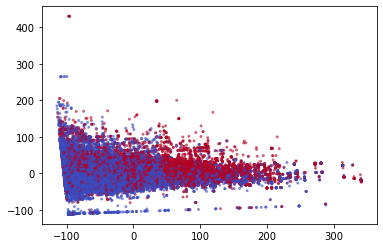

Epoch 1/20
674/674 [==============================] - 5s 5ms/step - loss: 0.4959 - accuracy: 0.7617
Epoch 2/20
674/674 [==============================] - 4s 5ms/step - loss: 0.4757 - accuracy: 0.7733
Epoch 3/20
674/674 [==============================] - 3s 5ms/step - loss: 0.4677 - accuracy: 0.7778
Epoch 4/20
674/674 [==============================] - 4s 5ms/step - loss: 0.4612 - accuracy: 0.7831
Epoch 5/20
674/674 [==============================] - 3s 5ms/step - loss: 0.4559 - accuracy: 0.7849
Epoch 6/20
674/674 [==============================] - 3s 5ms/step - loss: 0.4513 - accuracy: 0.7903
Epoch 7/20
674/674 [==============================] - 3s 5ms/step - loss: 0.4480 - accuracy: 0.7928
Epoch 8/20
674/674 [==============================] - 2s 3ms/step - loss: 0.4452 - accuracy: 0.7948
Epoch 9/20
674/674 [==============================] - 3s 4ms/step - loss: 0.4428 - accuracy: 0.7952
Epoch 10/20
674/674 [==============================] - 4s 5ms/step - loss: 0.4413 - accuracy: 0.7972

In [115]:
if __name__ == "__main__":
    main()